# Self-Driving Car Engineer Nanodegree


## Project: Advance Lane Finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [182]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
%matplotlib inline

out_dir='./output_images/'
mtx_dist_file = 'camera_dist_pickle.p'
def camera_calibrate(path):
    print("Calibrating camera path: " + path)
    images = glob.glob(path)#mpimg.imread(path)
    show_img = True
    for img_index, file_name in enumerate(images):
        img = mpimg.imread(file_name)
        obj_points = [] #3D points in real world space
        img_points = [] #2D points in image
        
        obj_point = np.zeros((6*9, 3), np.float32)
        obj_point[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            if show_img:
                plt.figure(figsize=(4,4))
                plt.imshow(img)
            img_points.append(corners)
            obj_points.append(obj_point)

            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            write_name = out_dir + 'image_point_' + str(img_index) + '.jpg'
            cv2.imwrite(write_name, img)
            if show_img:
                plt.figure(figsize=(4,4))
                plt.imshow(img)
                show_img = False
    print("Camera Calibrated")
    return obj_points, img_points

Calibrating camera path: ./camera_cal/calibration*.jpg
Camera Calibrated


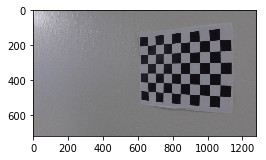

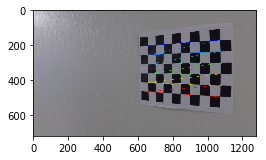

In [183]:
points = camera_calibrate('./camera_cal/calibration*.jpg')

In [184]:
def mtx_dist_get(path, obj_points, img_points):
    img = mpimg.imread(path)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (img.shape[0], img.shape[1])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, img_size, None, None)
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open(mtx_dist_file, "wb" ) )
    return img, undistorted_img

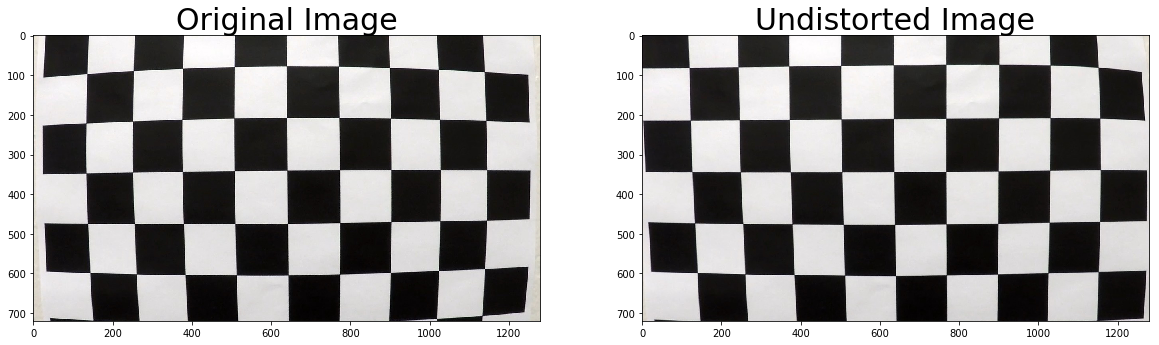

In [185]:
obj_points, img_points = points
original_image, undistorted_img = mtx_dist_get('./camera_cal/calibration1.jpg', obj_points, img_points)
write_name = out_dir + 'undistorted_' + 'calibration_1' + '.jpg'
cv2.imwrite(write_name, undistorted_img)

f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))
ax1.imshow(original_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=30)

In [186]:
def mtx_dist_load():
    dist_pickle = pickle.load(open(mtx_dist_file, "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    return mtx, dist

def images_undistort(path, mtx, dist):
    images_path = glob.glob(path)
    original_images = []
    undistorted_images = []
    for index, file_name in enumerate(images_path):
        img = mpimg.imread(file_name)
        original_images.append(img)
        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        undistorted_images.append(undistorted_img)
        write_name = out_dir + 'test_image_undistorted_' + str(index) + '.jpg'
        cv2.imwrite(write_name, undistorted_img)
    return original_images, undistorted_images

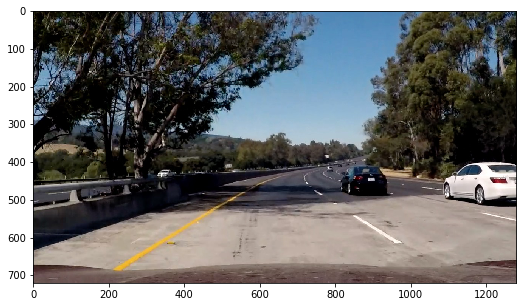

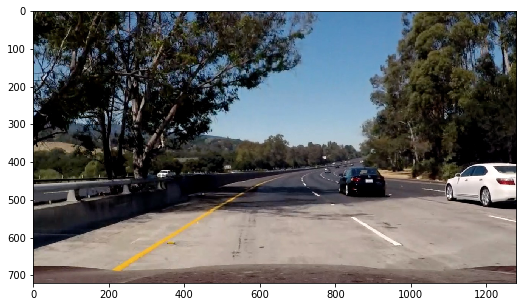

In [187]:
mtx, dist = mtx_dist_load()
original_images, undistorted_images = images_undistort('test_images/*.jpg', mtx, dist)
plt.figure(figsize=(10, 5))
plt.imshow(original_images[0])
plt.figure(figsize=(10, 5))
plt.imshow(undistorted_images[0])

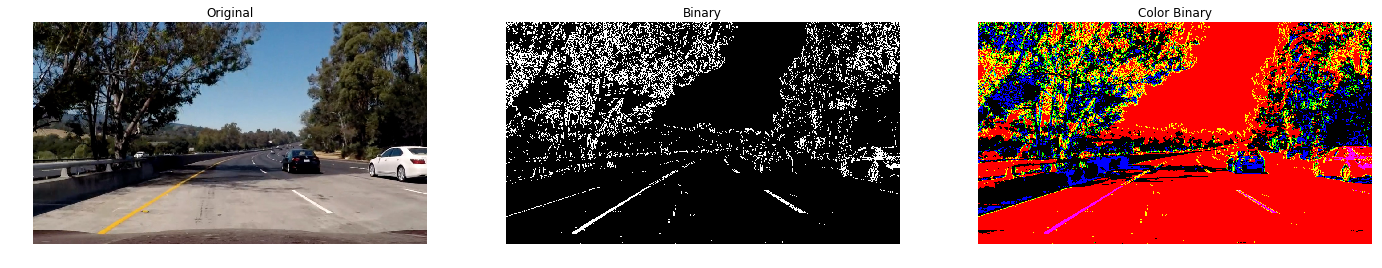

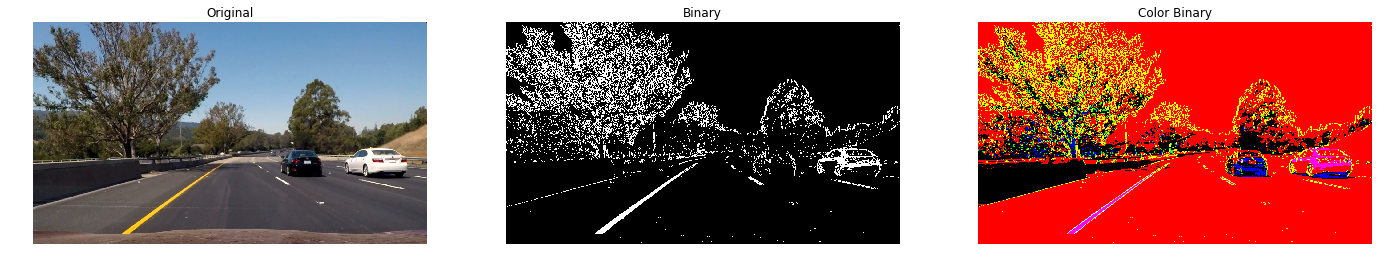

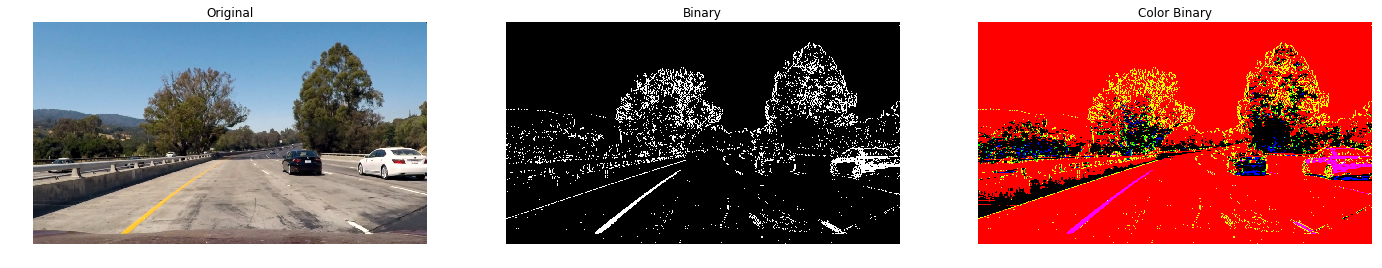

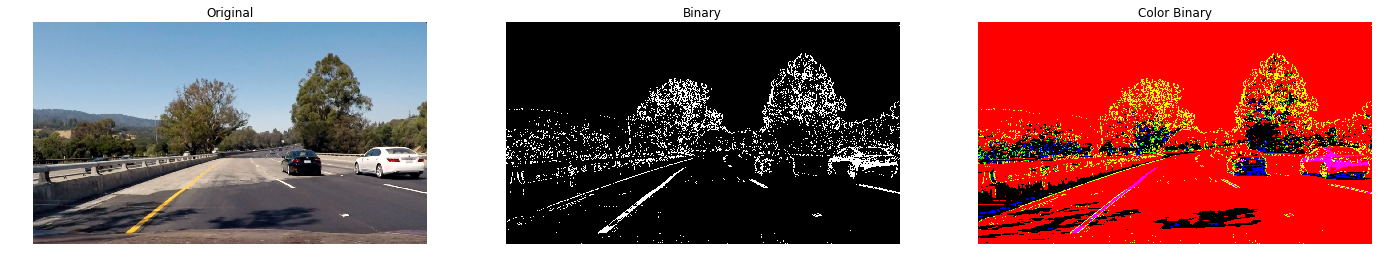

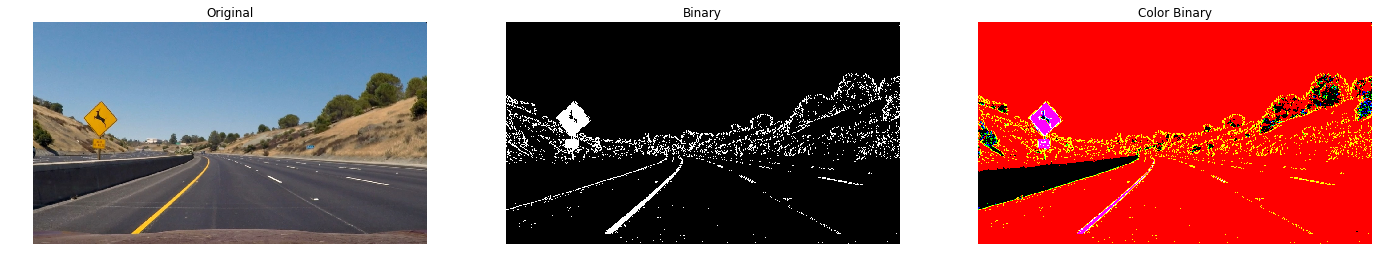

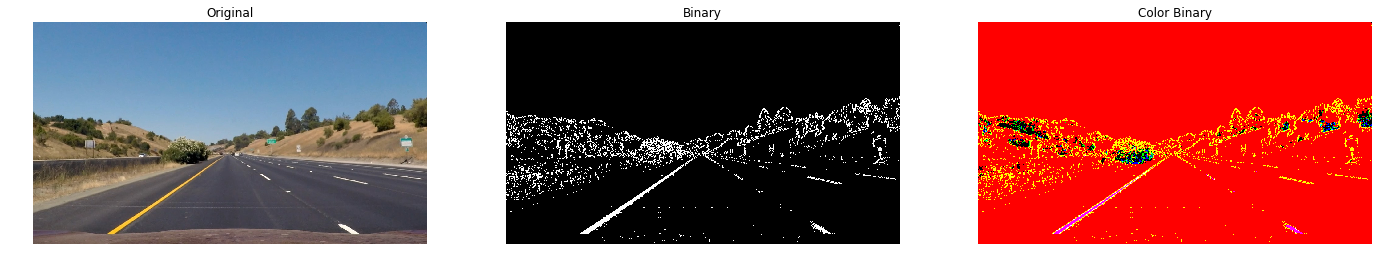

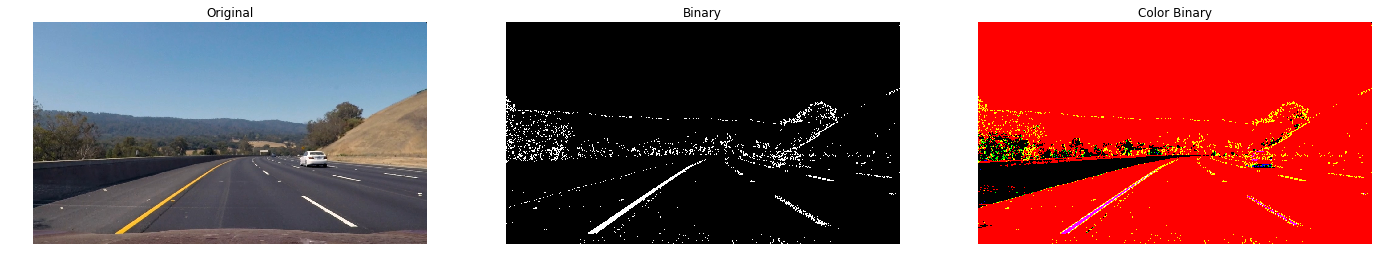

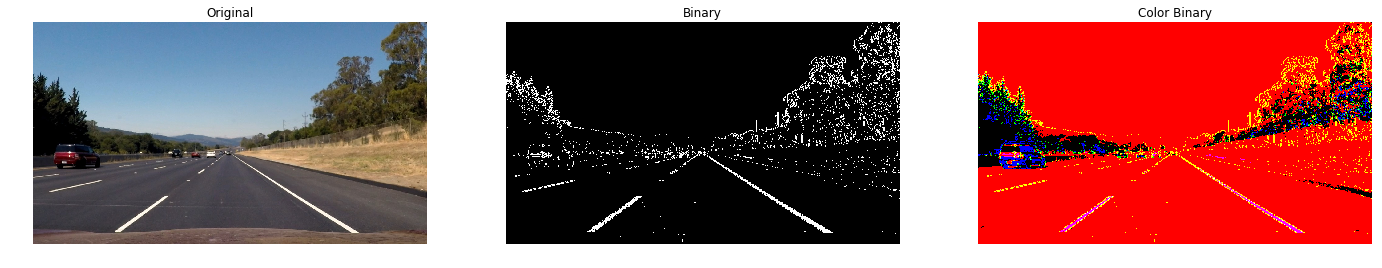

In [188]:
def color_thresh_apply(img, s_thresh=(170, 255), sx_thresh=(20, 100), l_thresh=(50,255)):
    undistorted_images = np.copy(img)
    # Convert to HLS color space and separate the H channel
    hls = cv2.cvtColor(undistorted_images, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold lightness
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Stack each channel
    color_binary = np.dstack((l_binary, sxbinary, s_binary)).astype('uint8') * 255
    
    binary = np.zeros_like(sxbinary)
    binary[((l_binary == 1) & (s_binary == 1) | (sxbinary==1))] = 1
    #binary = np.dstack((binary,binary,binary)).astype('uint8') * 255
    return binary, color_binary

binary_images = []
color_binary_images = []
for img_index, undistorted_img in enumerate(undistorted_images):
    binary, color_binary = color_thresh_apply(undistorted_img)
    
    binary_images.append(binary)
    color_binary_images.append(color_binary)
    
    fig, axs = plt.subplots(1, 3, figsize=(24, 9))
    axs = axs.ravel()
    axs[0].imshow(undistorted_img)
    axs[0].axis('off')
    axs[0].set_title("Original")
    
    axs[1].imshow(binary, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Binary")
    
    axs[2].imshow(color_binary)
    axs[2].axis('off')
    axs[2].set_title("Color Binary")

In [189]:
def image_warp(img):
    imshape = img.shape
    corners = np.array([(190,imshape[0]),((imshape[1]/2) - 56, imshape[0] * 0.63),
                          ((imshape[1]/2) + 70, imshape[0] * 0.63),
                          (imshape[1] - 145, imshape[0])], dtype=np.float32)
    new_top_left=np.array([corners[0,0],0])
    new_top_right=np.array([corners[3,0],0])

    offset=[150,0]
    imshape = (img.shape[1], img.shape[0]) 

    dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])
    src = corners
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, imshape , flags=cv2.INTER_LINEAR)    
    return warped, M, Minv, corners

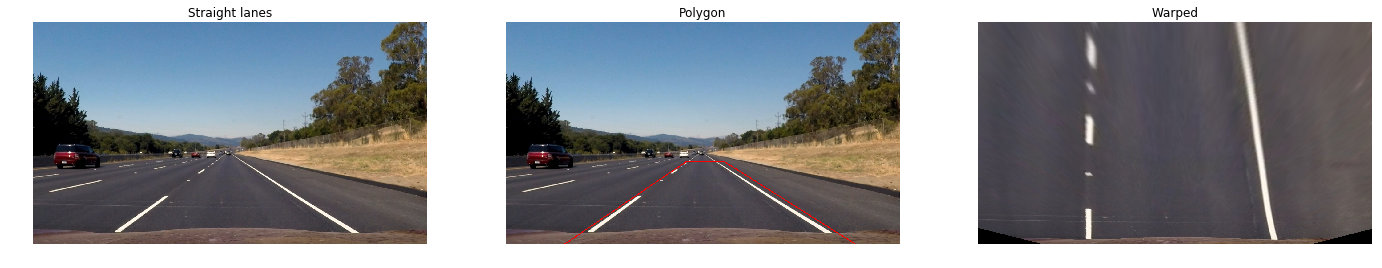

In [190]:
straight_image = np.copy(undistorted_images[len(undistorted_images) - 1])
warped_img, M, Minv, corners = image_warp(undistorted_images[len(undistorted_images) - 1])

fig, axs = plt.subplots(1, 3, figsize=(24, 9))
axs = axs.ravel()
axs[0].imshow(straight_image)
axs[0].axis('off')
axs[0].set_title("Straight lanes")

cv2.line(straight_image, tuple(corners[0]), tuple(corners[1]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[1]), tuple(corners[2]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[2]), tuple(corners[3]), color=[255,0,0], thickness=2)
cv2.line(straight_image, tuple(corners[3]), tuple(corners[0]), color=[255,0,0], thickness=2)

axs[1].imshow(straight_image)
axs[1].axis('off')
axs[1].set_title("Polygon")

axs[2].imshow(warped_img)
axs[2].axis('off')
axs[2].set_title("Warped")

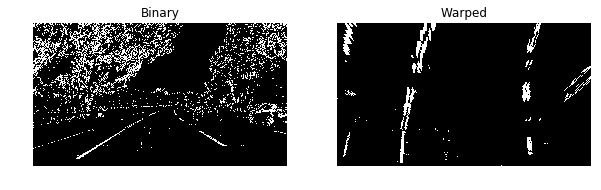

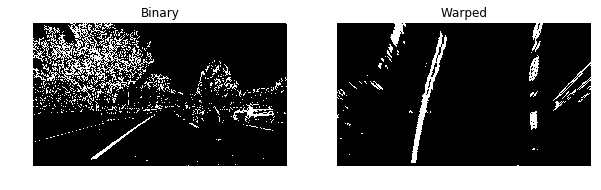

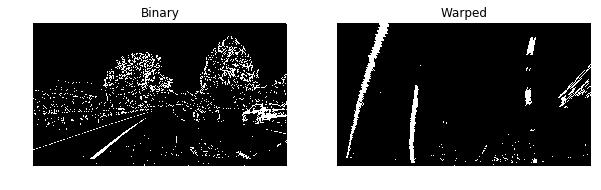

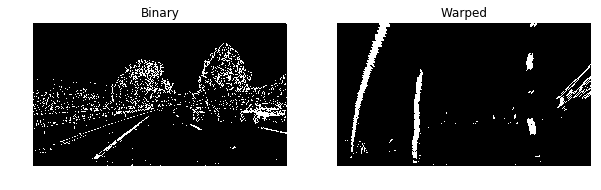

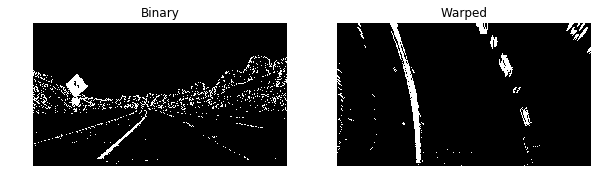

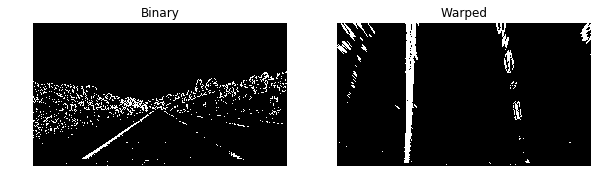

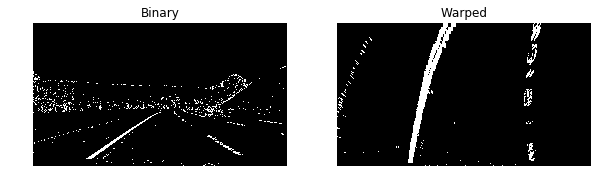

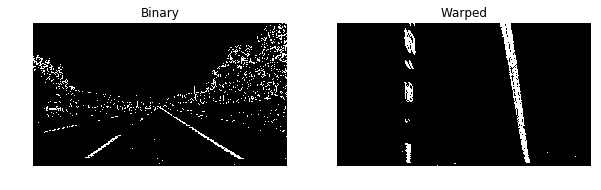

In [191]:
warped_images = []
for binary_image in binary_images:
    warped_image, M, Minv, corners = image_warp(binary_image)
    
    warped_images.append(warped_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = axs.ravel()
    axs[0].imshow(binary_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Binary")
    
    axs[1].imshow(warped_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Warped")

In [192]:
def region_of_interest_mask(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img) 
    shape = img.shape
    
    vertices_1 = np.array([[(1000,0),(shape[1]-100,0),(shape[1],0),(0.84*shape[1],shape[0]),
                      (shape[1]*0.16,shape[0]), (0,0)]],dtype=np.int32)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices_1, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)

    return masked_image

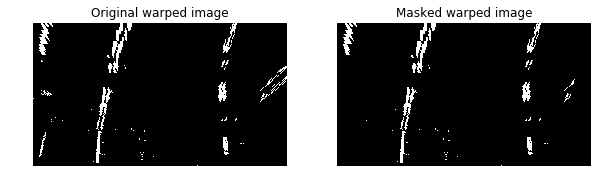

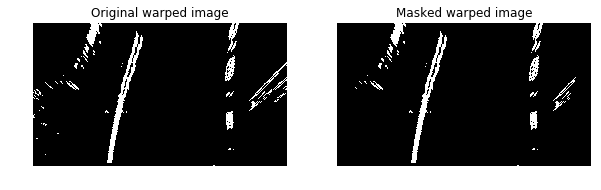

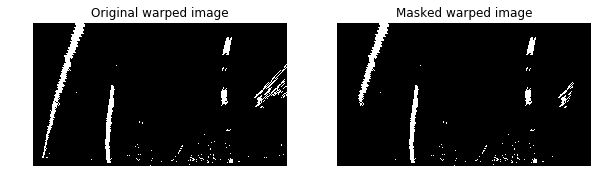

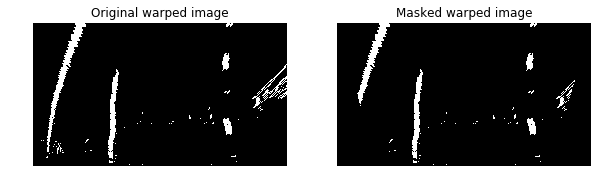

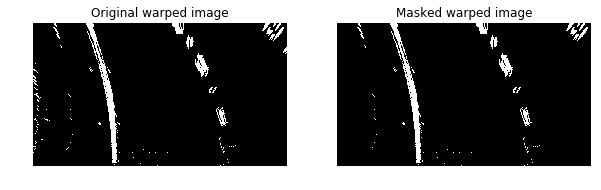

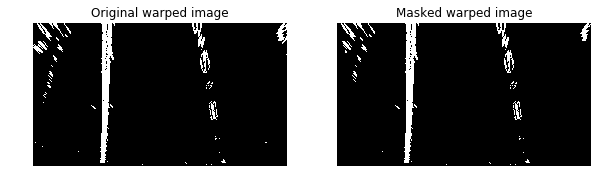

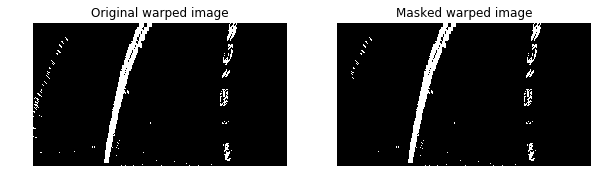

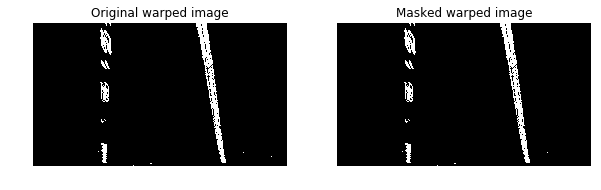

In [193]:
warped_images_masked = []
for warped_image in warped_images:
    masked_image = region_of_interest_mask(warped_image)
    
    warped_images_masked.append(masked_image)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs = axs.ravel()
    axs[0].imshow(warped_image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Original warped image")
    
    axs[1].imshow(masked_image, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Masked warped image")

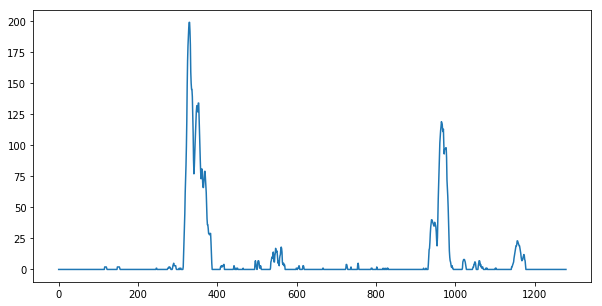

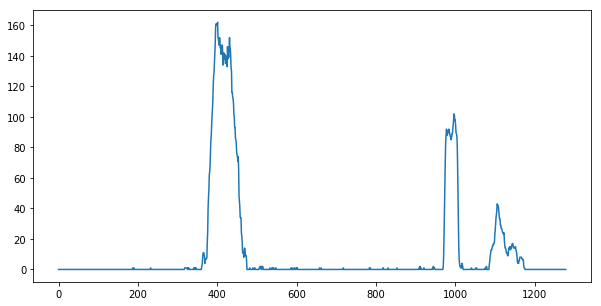

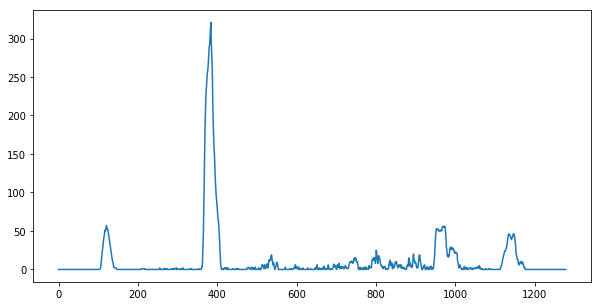

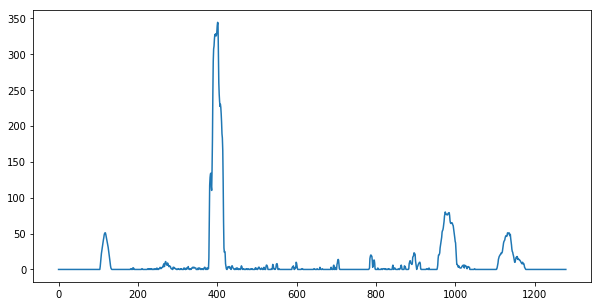

In [194]:
def histogram_get(images):
    for warped_image in images:
        histogram = np.sum(warped_image[warped_image.shape[0]//2:,:], axis=0)
        plt.figure(figsize=(10, 5))
        plt.plot(histogram)
histogram_get(warped_images_masked[:int(len(warped_images_masked)/2)])


In [201]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def draw_lines(out_img, ploty, left_fit, right_fit, margin):
    window_img = np.zeros_like(out_img)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fitx, right_fitx, result
    

In [202]:


def find_lines(binary_warped, margin):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)).astype('uint8') * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    #margin = 50
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    return ploty, left_fit, right_fit, left_fit_m, right_fit_m, out_img

In [207]:
def find_lines_no_slicing(binary_warped, left_fit, right_fit, margin):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    '''
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    '''
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return ploty, left_fit, right_fit, left_fit_m, right_fit_m, out_img

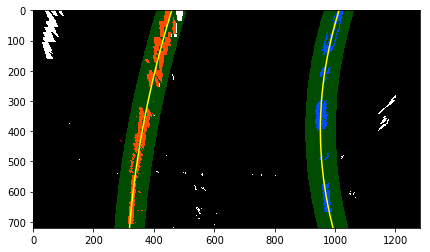

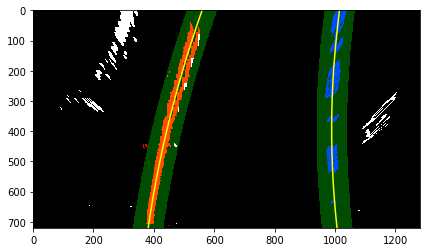

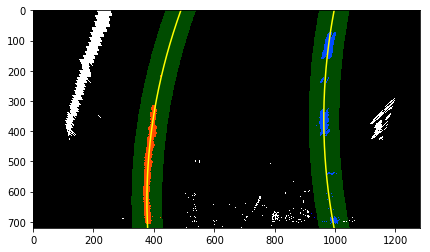

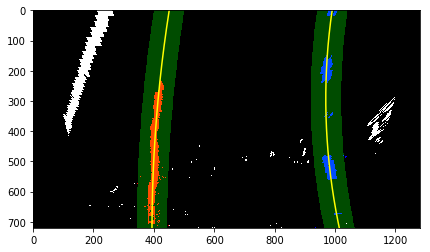

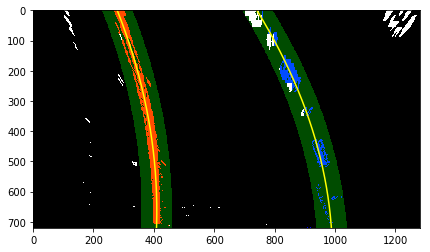

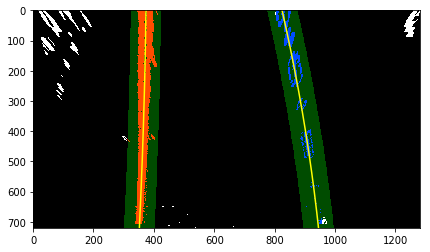

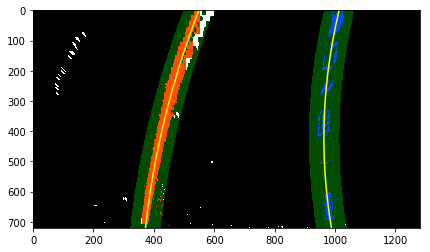

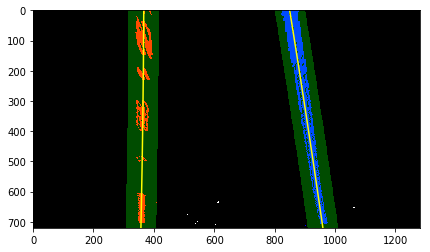

In [208]:
left_fitx_img = []
right_fitx_img = []
ploty_img = []
left_fit_m_img = []
right_fit_m_img = []
for img_index, image in enumerate(warped_images_masked):
    ploty, left_fit, right_fit, left_fit_m, right_fit_m, out_img = find_lines(image, 50)
    left_fitx, right_fitx, result_img = draw_lines(out_img, ploty, left_fit, right_fit, 50)
    left_fitx_img.append(left_fitx)
    right_fitx_img.append(right_fitx)
    left_fit_m_img.append(left_fit_m)
    right_fit_m_img.append(right_fit_m)
    ploty_img.append(ploty)
    plt.figure(figsize=(8, 4))
    plt.imshow(result_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [209]:
def curvature_calculate(y_eval, fit_meters):
    """
    Returns the curvature of the polynomial `fit` on the y range `yRange`.
    """
    
    return ((1 + (2*fit_meters[0]*y_eval*ym_per_pix + fit_meters[1])**2)**1.5) / np.absolute(2*fit_meters[0])

In [210]:
def original_img_lines_draw(undist, warped, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

In [211]:
def curvature_info_add(img, y_eval, left_fit_m_img, right_fit_m_img, left_curvature, right_curvature):
    line_left = 0
    line_right = 0
    line_middle = 0
    
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    line_left = left_fit_m_img[0]*yMax*yMax + left_fit_m_img[1]*yMax + left_fit_m_img[2]
    line_right = right_fit_m_img[0]*(yMax**2) + right_fit_m_img[1]*yMax + right_fit_m_img[2]
    line_middle = line_left + (line_right - line_left) / 2
    diffFromVehicle = line_middle - vehicleCenter
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
    
    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(img, 'Left curvature: {:.0f} m'.format(left_curvature), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Right curvature: {:.0f} m'.format(right_curvature), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(img, 'Vehicle is {} of center'.format(message), (50, 190), font, fontScale, fontColor, 2)
    
    return img

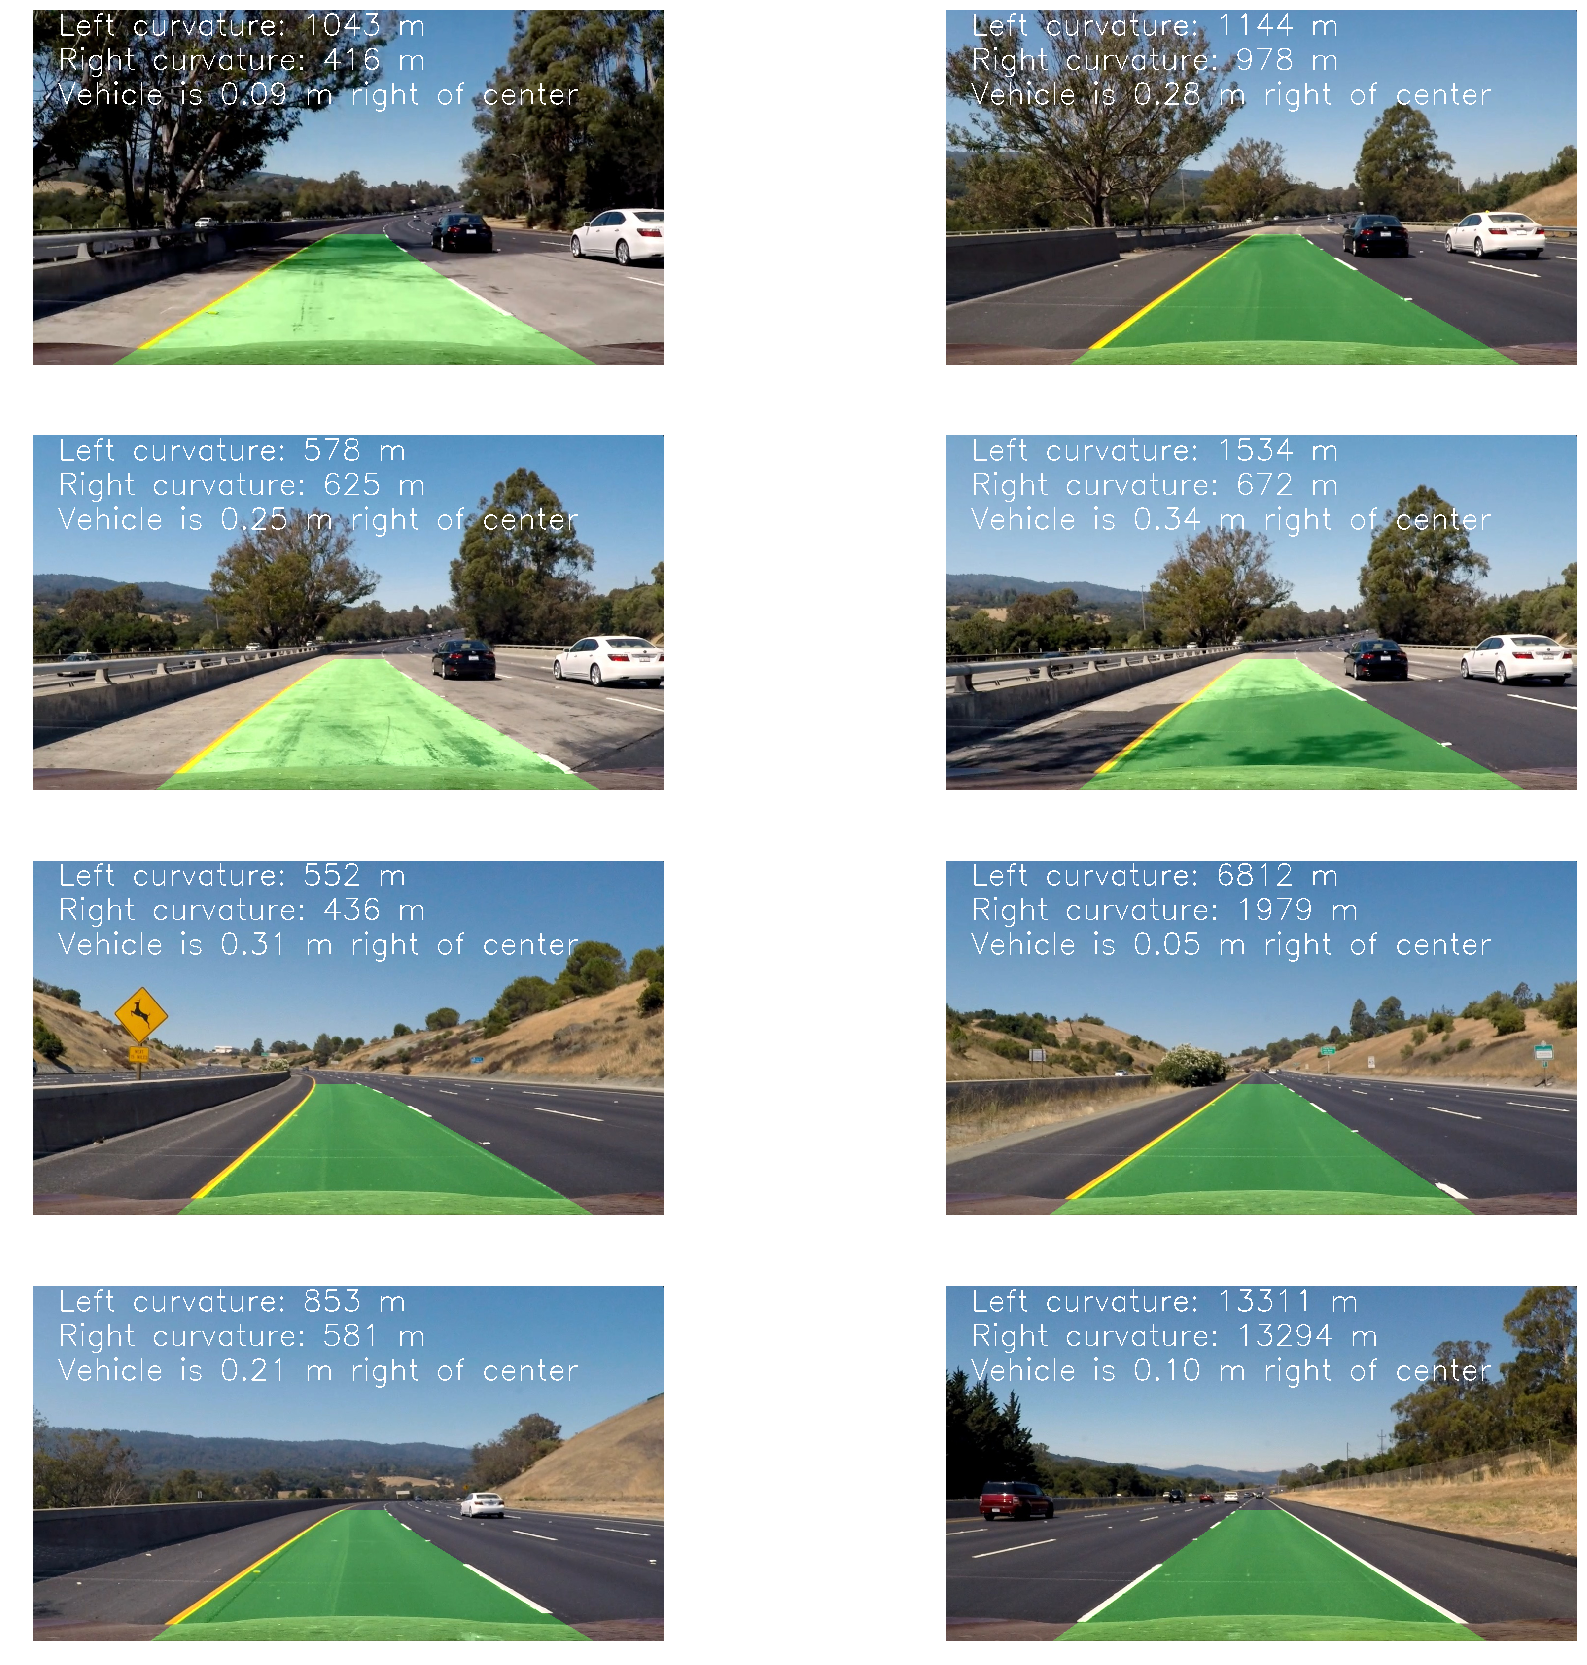

In [212]:
final_images = []
fig, axs = plt.subplots(4, 2, figsize=(30, 30))
for img_index, undistorted_img in enumerate(undistorted_images):
    y_eval = np.max(ploty_img[img_index])

    final_img = original_img_lines_draw(undistorted_images[img_index], warped_images_masked[img_index], 
                           left_fitx_img[img_index], right_fitx_img[img_index])
    left_curvature = curvature_calculate(y_eval, left_fit_m_img[img_index])
    right_curvature = curvature_calculate(y_eval, right_fit_m_img[img_index])
    final_img = curvature_info_add(final_img, y_eval, left_fit_m_img[img_index], right_fit_m_img[img_index],
                                  left_curvature, right_curvature)
    final_images.append(final_img)
    axs = axs.ravel()
    axs[img_index].imshow(final_img)
    axs[img_index].axis('off')

In [231]:
def pipeline(original_image, fits):
    mxt, dist = mtx_dist_load()
    
    undistorted_img = cv2.undistort(original_image, mtx, dist, None, mtx)
    
    binary_img, color_binary_img = color_thresh_apply(undistorted_img)
    
    warped_image, M, Minv, corners = image_warp(binary_img)
    
    warped_image = region_of_interest_mask(warped_image)
    
    ploty, left_fit, right_fit, left_fit_m, right_fit_m, out_img = find_lines(warped_image, 50)
    left_fitx, right_fitx, result_img = draw_lines(out_img, ploty, left_fit, right_fit, 50)
    # Calculate curvature
    left_curvature = curvature_calculate(np.max(ploty), left_fit_m)
    right_curvature = curvature_calculate(np.max(ploty), right_fit_m)
    
    new_fits = (left_fit, right_fit)
    fits_x = (left_fitx, right_fitx)
    fits_m = (left_fit_m, right_fit_m)
    curvatures =  (left_curvature, right_curvature)
    return ploty, new_fits, fits_x, fits_m, curvatures, warped_image

In [232]:
def draw_final_image(undistorted_img, warped_image, ploty, fitx, fit_m, curvatures):
    
    final_img = original_img_lines_draw(undistorted_img, warped_image, fitx[0], fitx[1])
    
    curvature_info_add(final_img, np.max(ploty), fit_m[0], fit_m[1], curvatures[0], curvatures[1])
    
    return final_img
    

In [233]:
class Lane():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

In [237]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'project_video_lanes.mp4'
clip1 = VideoFileClip("project_video.mp4")

first_lane = True
def videoPipeline(inputVideo, outputVideo):
    """
    Process the `inputVideo` frame by frame to find the lane lines, draw curvarute and vehicle position information and
    generate `outputVideo`
    """
    input_clip = VideoFileClip(inputVideo)
    
    leftLane = Lane()
    rightLane = Lane()
    def processImage(img):
        global first_lane
        fits = (leftLane.left_fit, rightLane.right_fit)
        ploty, new_fits, fits_x, fits_m, curvatures, warped_image = pipeline(img, fits)
        left_curvature, right_curvature = curvatures
        left_fit, right_fit = new_fits
        left_fit_m, right_fit_m = fits_m
        '''
        if first_lane:
            leftLane.left_fit = left_fitx
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = left_curvature
            rightLane.right_fit = right_fitx
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = right_curvature
            first_lane = False
        '''
        if left_curvature > 8000 or left_curvature < 100:
            left_fit = leftLane.left_fit
            left_fit_m = leftLane.left_fit_m
            left_curvature = leftLane.leftCurvature
        
        else:
            leftLane.left_fit = left_fit
            leftLane.left_fit_m = left_fit_m
            leftLane.leftCurvature = left_curvature
        
        if right_curvature > 8000 or right_curvature < 100:
            right_fit = rightLane.right_fit
            right_fit_m = rightLane.right_fit_m
            right_curvature = rightLane.rightCurvature
        else:
            rightLane.right_fit = right_fit
            rightLane.right_fit_m = right_fit_m
            rightLane.rightCurvature = right_curvature
        
        return draw_final_image(img, warped_image, ploty, fits_x, fits_m, curvatures)

    clip = input_clip.fl_image(processImage)
    clip.write_videofile(outputVideo, audio=False)

# Project video
videoPipeline('project_video.mp4', 'project_video_lanes.mp4')

[MoviePy] >>>> Building video project_video_lanes.mp4
[MoviePy] Writing video project_video_lanes.mp4


100%|█████████▉| 1260/1261 [02:23<00:00,  8.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_lanes.mp4 



In [235]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))